# Introducción a Detectron2 con Kaggle

Detectron2 es un framework de **Facebook AI Research (FAIR)** para tareas avanzadas de visión por computador, como:

- **Detección de objetos (Object Detection)** → localizar y clasificar objetos en una imagen.  
- **Segmentación de instancias (Instance Segmentation)** → no solo detectar, sino también delinear la forma del objeto.  
- **Detección de keypoints (Keypoint Detection)** → por ejemplo, articulaciones del cuerpo humano.  
- **Segmentación panóptica (Panoptic Segmentation)** → combinación de segmentación de instancias y semántica.  

---

## Objetivo del notebook
En este notebook vamos a realizar un **fine-tuning** de Detectron2 usando un dataset pequeño.  
Esto significa que:
- Partimos de un modelo ya entrenado en **COCO dataset**.  
- Lo ajustamos para detectar **nuevas clases** con un dataset más reducido.  

Esto es mucho más eficiente que entrenar desde cero y es la práctica más común en proyectos reales.  

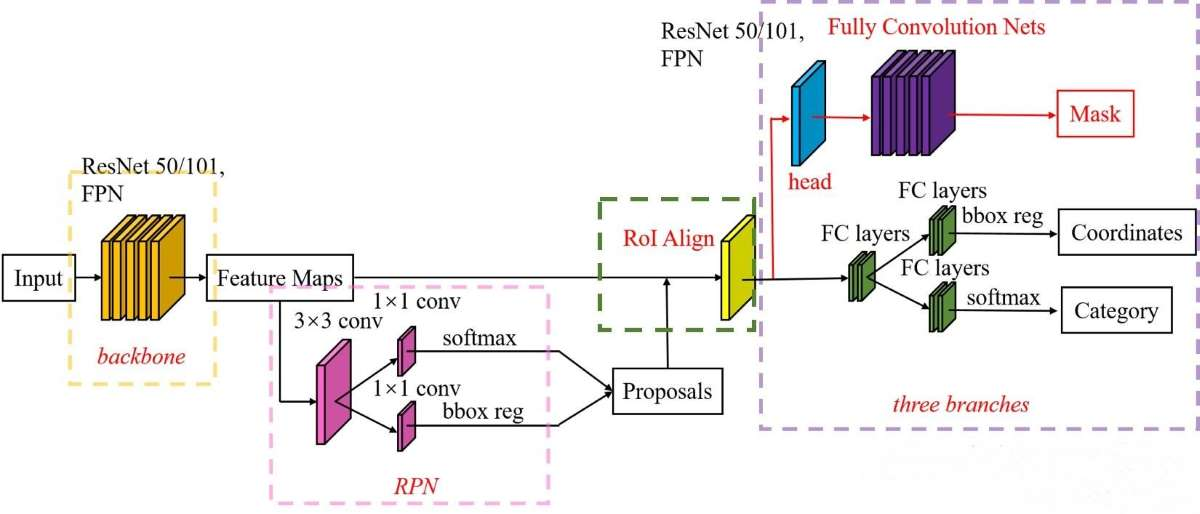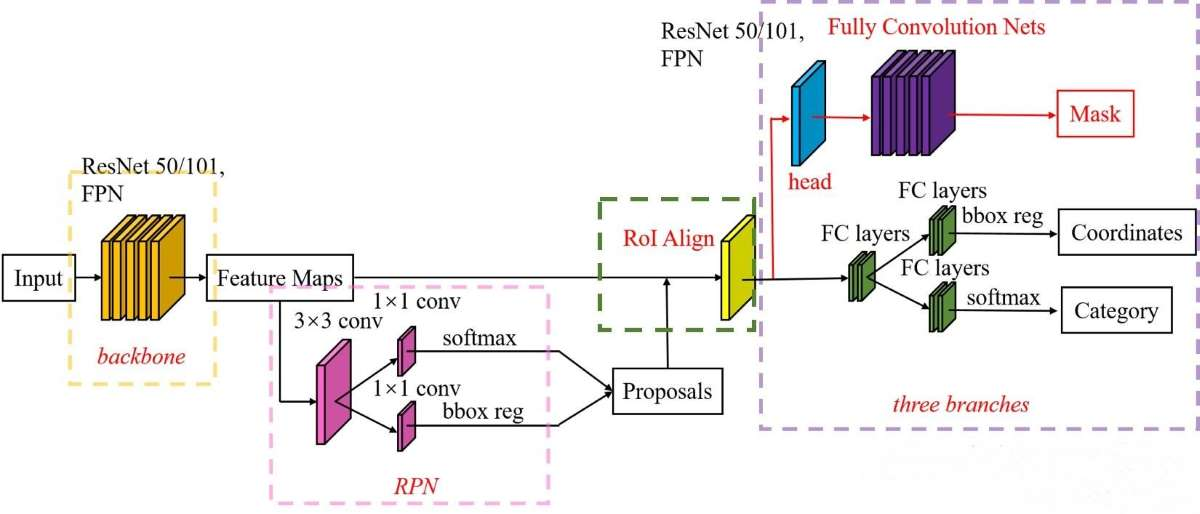

In [ ]:
!python -m pip install git+https://github.com/facebookresearch/detectron2.git

# Fase 1: Setup e instalación de Detectron2

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

c:\Users\ed\Documents\maestria\jupyter\Lib\site-packages\detectron2\model_zoo\model_zoo.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
#!wget http://images.cocodataset.org/val2017/000000282037.jpg -q -O input.jpg
!curl -L "http://images.cocodataset.org/val2017/000000282037.jpg" -o "input.jpg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  248k  100  248k    0     0   267k      0 --:--:-- --:--:-- --:--:--  267k


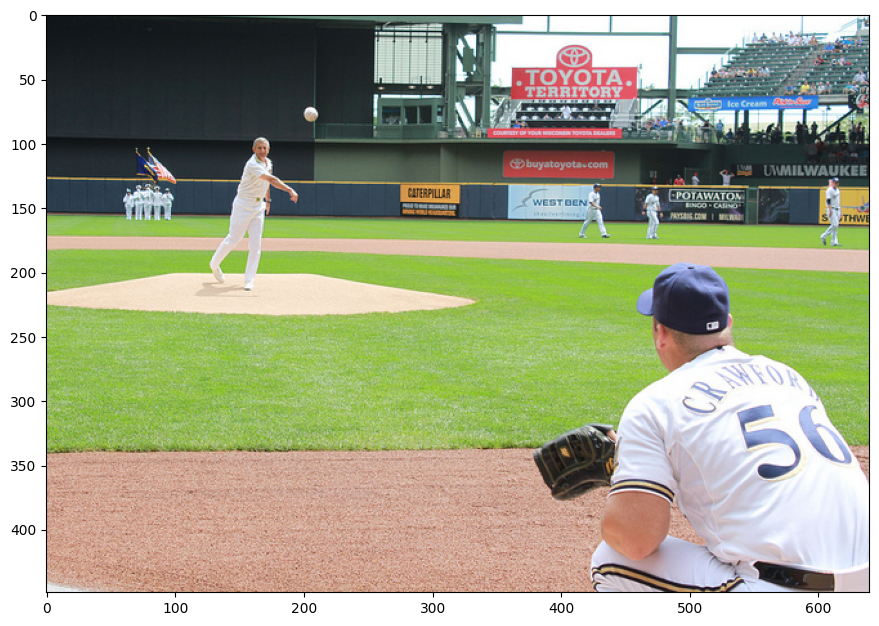

In [4]:
im = cv2.imread("./input.jpg")

plt.figure(figsize=(15,7.5))
plt.imshow(im[..., ::-1])

# Fase 2: Cargar y registrar el dataset

Para este ejercicio práctico vamos a usar el **Balloon Dataset**, un conjunto pequeño de imágenes de globos con anotaciones.

¿Por qué este dataset?
- Es liviano y rápido de descargar.
- Ya está en formato COCO (compatible con Detectron2).
- Perfecto para mostrar un **fine-tuning** sin tardar horas.


In [5]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im[..., ::-1])

# Force CPU since your Torch has no CUDA
#cfg.MODEL.DEVICE = "cpu"
#predictor = DefaultPredictor(cfg)

print(outputs["instances"].pred_classes)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

namespace(name='coco_2017_train',
          json_file='datasets/coco/annotations/instances_train2017.json',
          image_root='datasets/coco/train2017',
          evaluator_type='coco',
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             4: 3,
                                             5: 4,
                                             6: 5,
                                             7: 6,
                                             8: 7,
                                             9: 8,
                                             10: 9,
                                             11: 10,
                                             13: 11,
                                             14: 12,
                                             15: 13,
                                             16: 14,
                                   

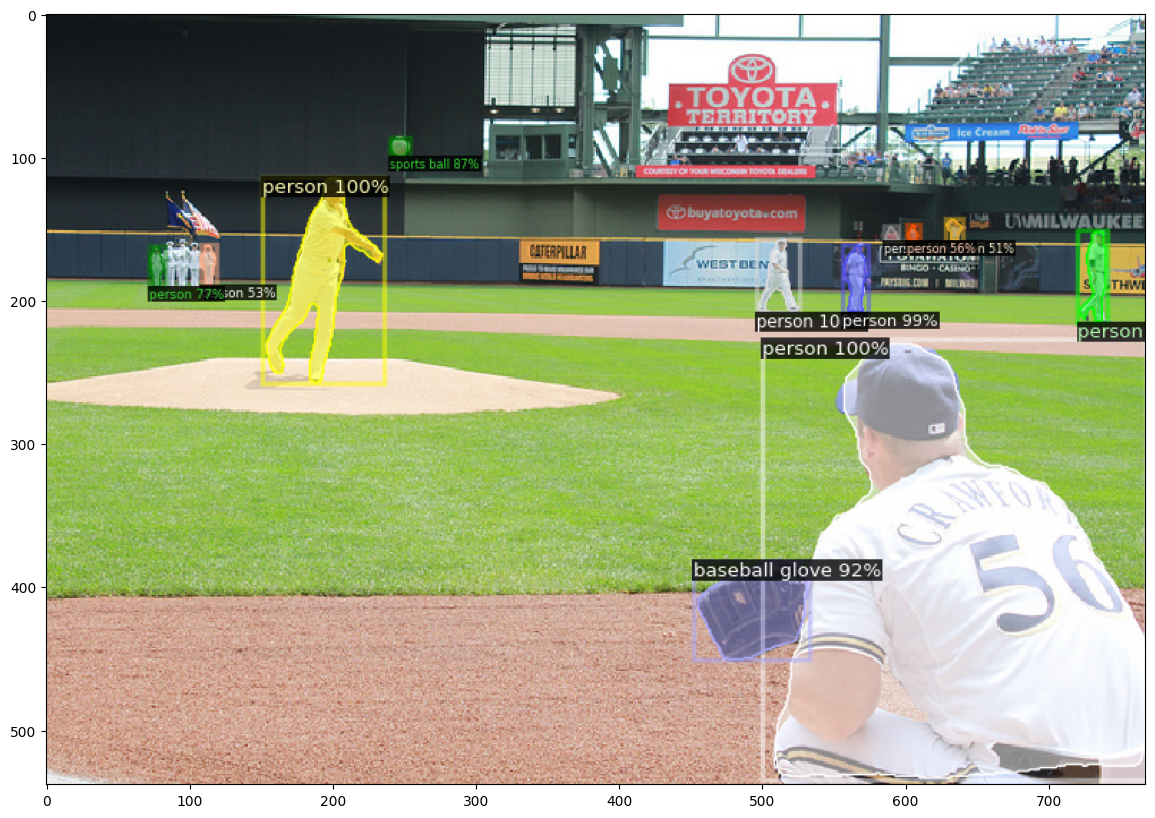

In [ ]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(out.get_image()[..., ::-1][..., ::-1])

In [ ]:
import os
import urllib.request
import zipfile

url = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"
zip_path = "balloon_dataset.zip"

if not os.path.exists(zip_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, zip_path)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(".")

print("Extracted content in:", os.listdir("."))

Extracted content in: ['balloon', '__MACOSX', 'input.jpg', 'balloon_dataset.zip', '.virtual_documents']


In [ ]:
from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

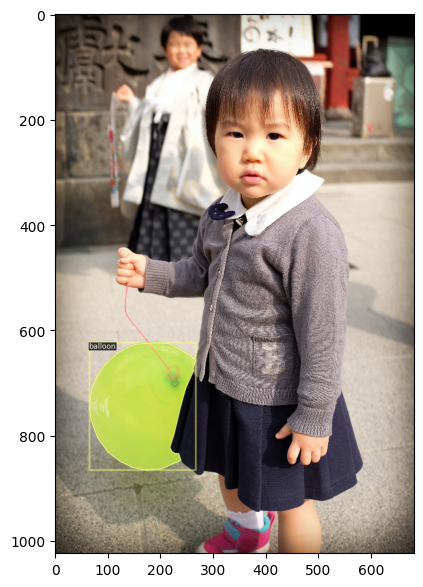

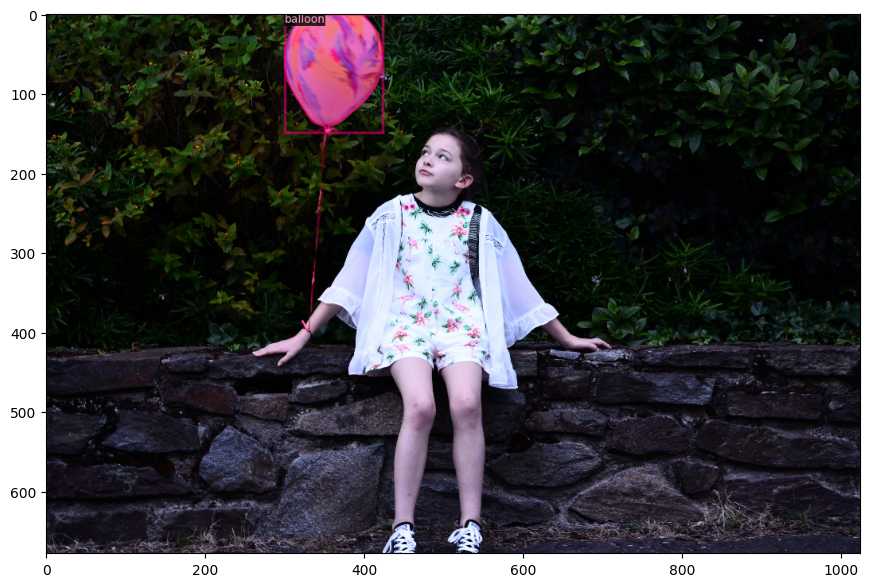

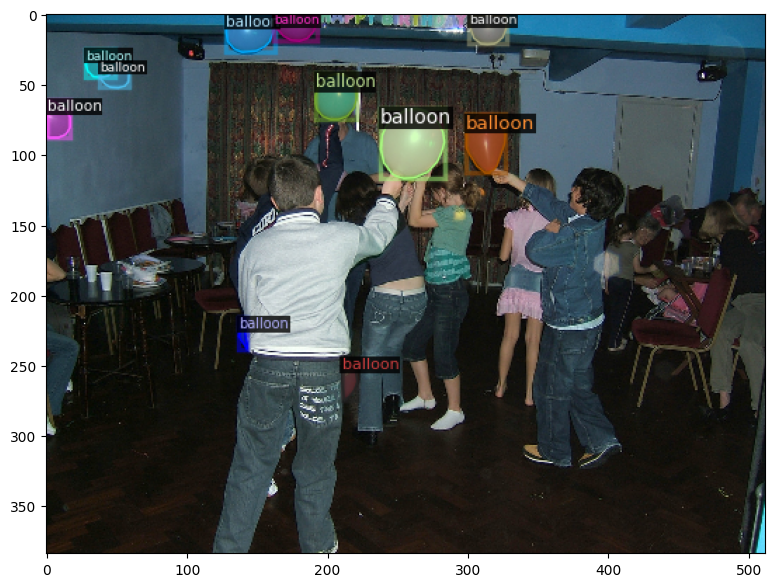

In [ ]:
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(15,7))
    plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

# Fase 3: Configuración del modelo y Fine-Tuning

En esta fase vamos a:

1. Cargar un modelo preentrenado de Detectron2 (Mask R-CNN con ResNet-50 + FPN entrenado en COCO).  
2. Ajustarlo para detectar nuestra clase "balloon".  
3. Configurar hiperparámetros clave: learning rate, batch size, número de iteraciones.  
4. Entrenar el modelo usando **fine-tuning**, aprovechando que ya viene preentrenado.

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025 
cfg.SOLVER.MAX_ITER = 300    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/11 04:35:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

2025-09-11 04:35:50.472424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757565350.684184      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757565350.748117      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[09/11 04:36:08 d2.utils.events]:  eta: 0:01:09  iter: 39  total_loss: 1.849  loss_cls: 0.5255  loss_box_reg: 0.649  loss_mask: 0.6063  loss_rpn_cls: 0.05449  loss_rpn_loc: 0.008221    time: 0.2690  last_time: 0.2752  data_time: 0.0058  last_data_time: 0.0052   lr: 3.2718e-05  max_mem: 2633M
[09/11 04:36:13 d2.utils.events]:  eta: 0:01:04  iter: 59  total_loss: 1.661  loss_cls: 0.4617  loss_box_reg: 0.6417  loss_mask: 0.495  loss_rpn_cls: 0.02301  loss_rpn_loc: 0.009354    time: 0.2685  last_time: 0.2445  data_time: 0.0064  last_data_time: 0.0095   lr: 4.9367e-05  max_mem: 2633M
[09/11 04:36:18 d2.utils.events]:  eta: 0:00:57  iter: 79  total_loss: 1.507  loss_cls: 0.3504  loss_box_reg: 0.6748  loss_mask: 0.3416  loss_rpn_cls: 0.02072  loss_rpn_loc: 0.002803    time: 0.2656  last_time: 0.2627  data_time: 0.0062  last_data_time: 0.0085   lr: 6.6017e-05  max_mem: 2703M
[09/11 04:36:23 d2.utils.events]:  eta: 0:00:53  iter: 99  total_loss: 1.361  loss_cls: 0.2961  loss_box_reg: 0.6704  lo

[09/11 04:37:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


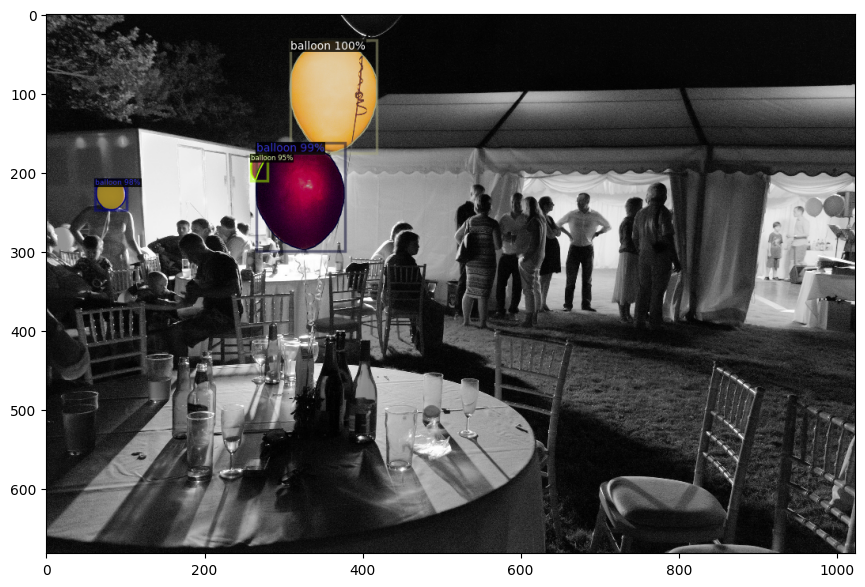

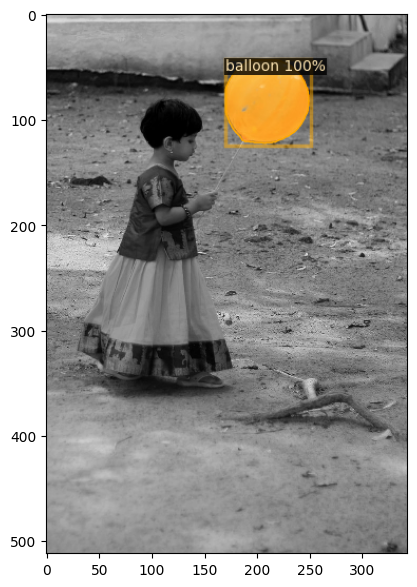

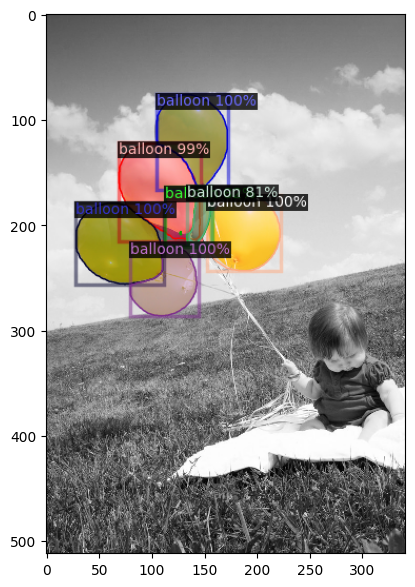

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im) 
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(15,7))
    plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

## Test

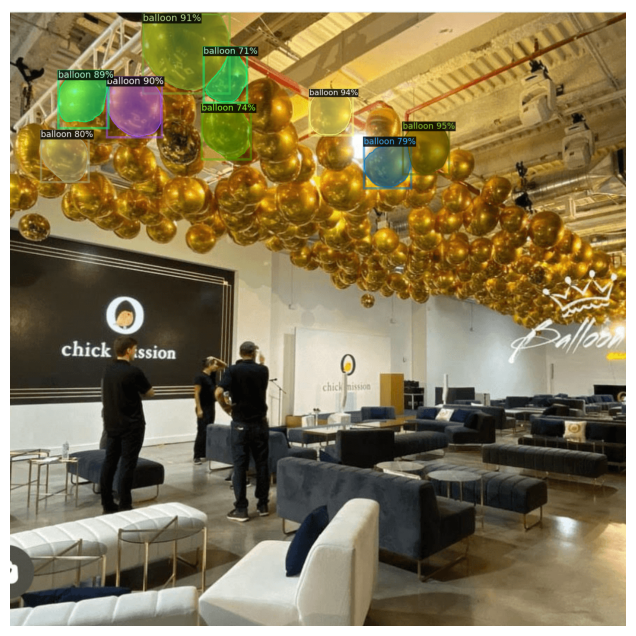

In [ ]:
import requests
from io import BytesIO
image_url = "https://cdn11.bigcommerce.com/s-af2f8xc7r2/images/stencil/1280w/uploaded_images/balloon-kings-nj.png"
response = requests.get(image_url)
image_bytes = BytesIO(response.content)
im = np.array(cv2.imdecode(np.frombuffer(image_bytes.read(), np.uint8), cv2.IMREAD_COLOR))

if im is None:
    raise ValueError("It didn't load the image")
    
outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(10, 8))
plt.imshow(out.get_image())
plt.axis("off")
plt.show()


## Exercises

1. Reduce the number of training examples by half. Compare training time, predictions, and loss.

2. Increase the learning rate and analyze the results.

3. Modify the test threshold to make a better prediction

4. Increase the maximum number of iterations and note the impact.

5. Test with your own image and summarize your observations.